# <img src="https://raw.githubusercontent.com/alsinmr/SLEEPY_tutorial/033b817f027ebdcd6493a1f42ab9fdec290dbee8/JupyterBook/favicon.png"  width=40> <font  color = "#0093AF">$T_1$ and Nuclear Overhauser Effect</font>

In the following, we will mimic $T_1$ relaxation and heteronuclear NOE transfer resulting from tumbling in solution. To do this, we would like to have a motion that averages the dipolar tensor to zero. A simple way to do this is to use a tetrahedral hopping motion, however, note that this only results in isotropic averaging to interactions that are initially aligned along the $z$-axis.

## Setup

In [0]:
# SETUP SLEEPY
!pip install sleepy-nmr

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the spin-system
An important consideration when simulating longitudinal relaxation is that this type of relaxation is induced by interactions that are removed when using the rotating frame approximation. Therefore, we must be sure to setup our spin system in the lab frame. You can try running these calculations in the rotating frame to see that the $T_1$ relaxation vanishes.

Note that adding explicit relaxation (via `L.add_relax(...)`) does not require a lab-frame calculation.

We start with a 1-bond H–N dipole coupling, hopping around a tetrahedral geometry, with a correlation time of 1 ns. The tool `sl.Tools.SetupTumbling` takes `ex0` and rotates to several orientations (for higher `q`, we get more orientations), and returns a Liouvillian with different the Euler angles in exchange. The exchange matrix in the resulting Liouvillian yields an approximately monoexponential correlation function (for `q=0` or `q=1`, it is exactly monoexponential, but for higher values, it is only approximate). Note that `SetupTumbling` averages around the α- and β-angles, but not γ, so be cautious for more complex geometries.

In [3]:
# By default, we get a powder average when including anisotropic terms.
# so we set it explicitly to a 1-element powder average
ex0=sl.ExpSys(v0H=400,Nucs=['15N','1H'],vr=0,LF=True,pwdavg='alpha0beta0')
delta=sl.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)

# Set up 4-site motion
L=sl.Tools.SetupTumbling(ex0,tc=1e-9,q=1) #q=1 gives just the tetrahedral orientations

seq=L.Sequence(Dt=.1)

## Simulate $T_1$ relaxation of $^1$H and $^{15}$N

We start with both the $^{15}$N and $^1$H nuclei at thermal equilibrium (`rho0='Thermal'`) and observe decay of magnetization due to the motion. 

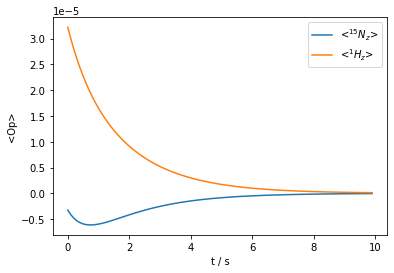

In [4]:
rho=sl.Rho(rho0='Thermal',detect=['15Nz','1Hz'])
rho.DetProp(seq,n=100)
_=rho.plot(axis='s')

We observe both spins start from their thermal equilibrium and decay towards zero. The $^{15}$N magnetization is briefly enhanced by magnetization from the $^1$H spin, but then decays together with the $^1$H.

## Relaxing towards thermal equilibrium
Note that exchange in simulations only can destroy magnetization, so that this approach always forces the magnetization towards zero. We may add a correction term in SLEEPY, that will cause the magnetization to approach thermal equilibrium rather than zero. This is included by running `L.add_relax('DynamicThermal')`. Then, we can start the magnetization at zero (`rho0='zero'`) and allow both spins to recover.

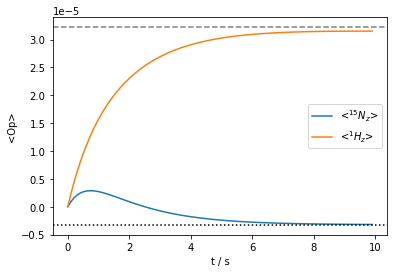

In [5]:
L.add_relax('DynamicThermal')
rho=sl.Rho(rho0='zero',detect=['15Nz','1Hz'])
rho.DetProp(seq,n=100)
ax=rho.plot(axis='s')
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(),ex0.Peq[0]*np.ones(2),linestyle=':',color='black')
_=ax.plot(ax.get_xlim(),ex0.Peq[1]*np.ones(2),linestyle='--',color='grey')

`'DynamicThermal'` works by calculating the full Liouvillian (referred to here as $\hat{\hat{L}}_0$) and equilibrium density matrix, $\hat{\rho}_{eq}$. Then, a correction term is calculated, such that:

$$
\hat{\rho}_{corr}=-\hat{\hat{L}}_0\cdot\hat{\rho}_{eq}
$$

Then, if $\hat{\rho}=\hat{\rho}_{eq}$, the sum of the product of the Liouvillian and the density matrix plus the correction term is zero:

$$
\frac{d}{dt}\hat{\rho}=\hat{\hat{L}}_0\cdot\hat{\rho}+\hat{\rho}_{corr}
$$

The correction term is inserted into the Liouvillian such that it only interacts with the identity in the density matrix. Remember, the density matrix is extended to a vector in Liouville space. However, take for example, a 2-spin-1/2 system. The 4x4 identity matrix is stretched into a 16 element vector, with elements at the 0th, 5th, 10th, and 15th position. In this system, we have four states in exchange, so that yields elements at positions: 0,5,10,15,16,21,26,31,32,37,42,47,48,53,58,63. We can see how this works in the plot below, where the columns corresponding to the listed positions are each occupied by the product $\hat{\hat{L}}_0\cdot\hat{\rho}_{eq}$

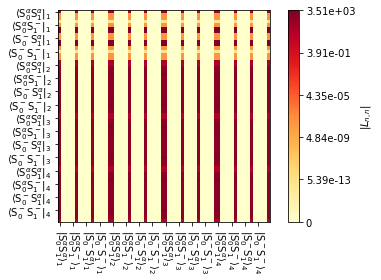

In [6]:
_=L.plot('Lrelax')

Then, it is important to note: this correction will result in polarization on, for example, the $\hat{S}_z$ term, by continually reducing the population of $\hat{S}_\beta$ and increasing the population of $\hat{S}_\alpha$, whereas the rest of the Liouvillian is continuously try to equilibrate these populations. However, we also expect asymmetric transfer between, for example, the $\hat{I}^+\hat{S}_\alpha$ and $\hat{I}^+\hat{S}_\beta$ populations. This is what gives rise to the [contact shift](../Chapter5/Ch5_ContactShift.ipynb) occuring due to fast relaxing electrons. However, both the $\hat{I}^+\hat{S}_\alpha$ and $\hat{I}^+\hat{S}_\beta$ terms are zero under thermal conditions, and therefore are not included in the "DynamicThermal" correction term, as we can see above where we note that the correction is calculated from the density matrix at thermal equilibrium, $\hat{\rho}_{eq}$. We will later see that we can correctly produce contact and pseudo-contact shifts using Lindblad formalism,$^1$ but this is obtained with a different set of settings which we will use later for paramagnetic effects.

[1] C. Bengs, M. Levitt. [*J. Magn. Reson.*](https://doi.org/10.1016/j.jmr.2019.106645). **2020**, 310,106645.

We note that the 'DynamicThermal' option is susceptible to numerical error due to the small size of the correction compared to the large exchange rates possible. Please see [$T_1$ tests](Ch2_T1_limits.ipynb) for more details.

## Obtaining the NOE enhancement

Finally, we may observe how saturating one spin can lead to a change in the magnetization on the second spin via the Nuclear Overhauser Effect.$^2$

Here, we have to use a special tool in SLEEPY to apply an oscillating RF field in the lab frame. Keep in mind, longitudinal relaxation is driven by terms in the Hamiltonian that are dropped when we go to the rotating frame, so a lab frame calculation is required. However, in the lab frame, the applied RF fields are no longer time-independent and their time-dependence needs to be explicitly simulated. SLEEPY uses several tricks for doing this. First, we use a two-step square wave to produce the correct frequency, and scale it to produce the correct amplitude at center frequency band. The resulting propagator is then brought into its eigenbasis and propagated either to one step in a rotor period, or here just to the desired length of the propagator. It should be noted that this approach does indeed produce sidebands to the RF, but we do not have any indication that this negatively impacts the simulations. 

[2] A.W. Overhauser. [*Phys. Rev.*](https://doi.org/10.1103/PhysRev.92.411), **1953**, 92, 411-415.

In [7]:
L.kex=sl.Tools.fourSite_sym(tc=1e-9)

seq=L.Sequence(Dt=.1).add_channel('1H',v1=500)
#The lfrf object creates a propagator with a fixed
#field strength on one channel, 
#and length equal to the input sequence length (0.1 s)
lfrf=sl.LFrf(seq)

Below, we plot the square wave used to produce RF-irradiation in the lab frame.

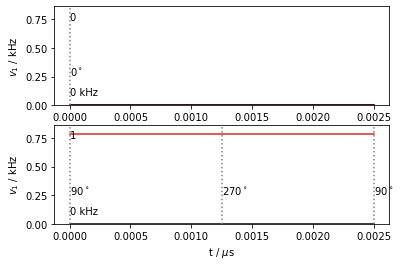

In [8]:
_=lfrf.seq.plot()

First, we get the propagator for the lab-frame RF. Then, we apply it to a system at thermal equilibrium, to observe it evolve away from thermal equilibrium due to the RF irradation saturating the $^1$H.

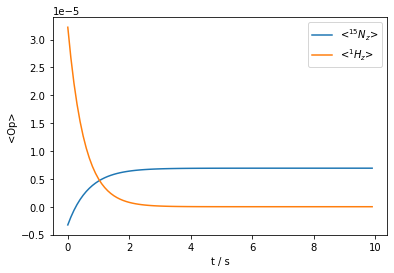

In [9]:
U=lfrf.U(progress=False)

rho=sl.Rho('Thermal',['15Nz','1Hz'])
rho.DetProp(U,n=100)
_=rho.plot(axis='s')

In [10]:
print(f'Enhancement: {rho.I[0][-1].real/ex0.Peq[0]:.1f}')

Enhancement: -2.1


Then, the $^1$H magnetization is saturated, and the $^{15}$N signal switches from negative to positive and is enhanced by just over a factor of 2.

We finally calculate the correlation time dependence of the NOE enhancement.

In [11]:
seq=L.Sequence(Dt=.1).add_channel('1H',v1=5000)
rho=sl.Rho('Thermal','15Nz')

tc0=np.logspace(-10,-7.5,50)
for tc in tc0:
    rho.reset()
    L.kex=sl.Tools.fourSite_sym(tc=tc)
    lfrf=sl.LFrf(seq)
    U=lfrf.U(progress=False)
    (U**np.inf*rho)()

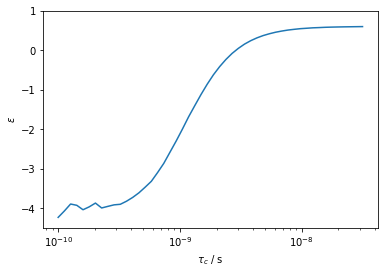

In [12]:
ax=plt.subplots()[1]
ax.semilogx(tc0,rho.I[0].real/ex0.Peq[0])
ax.set_ylim([-4.5,1])
ax.set_xlabel(r'$\tau_c$ / s')
_=ax.set_ylabel(r'$\varepsilon$')


We then get the expected enhancement values for an H–N heteronuclear NOE. A little noise appears at short correlation times where the `DynamicThermal` method is less numerically stable. Limits to this method are discussed in detail in [T$_1$tests](Ch2_T1_limits.ipynb).